In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
sns.set_theme(style='white', context='notebook', font_scale=1.33)

## Section 1: Model Comparison

In [2]:
for m in ['1pl_m1','1plg_m1','1pl_m2','1plg_m2',
          '1pl_m3','1plg_m3','1pl_m4','1plg_m4',
          '3pl_m1','3pl_m2','3pl_m3']:
    
    ## Load ppc.
    ppc = read_csv(os.path.join('stan_results', f'{m}_ppc.csv'))
        
    ## Model comparison.
    louo = ppc.louo.sum()
    loco = ppc.groupby('subject').loco.mean().sum()
    pwaic_u = ppc.pwaic_u.sum()
    pwaic_c = ppc.groupby('subject').pwaic_c.mean().sum()
    
    print('%s:  %0.2f | %0.2f | %0.2f | %0.2f' %(m, louo, loco, pwaic_u, pwaic_c))

1pl_m1:  -15140.45 | -14812.98 | 723.22 | 111.96
1plg_m1:  -14590.84 | -14516.85 | 688.06 | 93.29
1pl_m2:  -14449.25 | -14123.63 | 728.08 | 151.90
1plg_m2:  -13894.20 | -13804.74 | 698.60 | 159.38
1pl_m3:  -14133.48 | -13813.92 | 708.43 | 153.37
1plg_m3:  -13577.38 | -13481.12 | 678.57 | 164.26
1pl_m4:  -13940.93 | -13609.79 | 836.64 | 264.51
1plg_m4:  -13403.62 | -13293.16 | 842.29 | 339.87
3pl_m1:  -13373.54 | -13209.38 | 1036.22 | 384.90
3pl_m2:  -13371.76 | -13207.25 | 1054.47 | 408.13
3pl_m3:  -13374.02 | -13208.69 | 1069.05 | 426.78


In [3]:
from itertools import combinations

for a, b in list(combinations(['3pl_m1','3pl_m2','3pl_m3'], 2)):
    
    ## Load data.
    df1 = read_csv(os.path.join('stan_results', f'{a}_ppc.csv'))
    df2 = read_csv(os.path.join('stan_results', f'{b}_ppc.csv'))
    
    arr = df2.groupby('subject').loco.mean() - df1.groupby('subject').loco.mean()
    
    ## Compute stats.
    N = df1.subject.nunique()
    mu = np.sum(arr)
    se = np.std(arr) * np.sqrt(N)
    
    print(f'{b} - {a}: %0.3f (%0.3f)' %(mu, se))

3pl_m2 - 3pl_m1: 2.128 (2.044)
3pl_m3 - 3pl_m1: 0.690 (2.202)
3pl_m3 - 3pl_m2: -1.438 (0.855)


## Explained variance

#### 1plg_m4

In [4]:
## Load samples.
samples = read_csv(os.path.join('stan_results', '1plg_m4.tsv.gz'), sep='\t', compression='gzip')

## Extract parameters.
beta_mu   = samples.filter(regex='beta_mu\[').values
beta_1_pr = samples.filter(regex='beta_1_pr\[').values
beta      = samples.filter(regex='beta\[').values
sigma     = samples.filter(regex='sigma\[').values

## Load and prepare design matrices.
zscore = lambda x: (x - np.nanmean(x)) / np.nanstd(x)
X2 = read_csv(os.path.join('designs', 'X2.csv'))
X2 = X2.apply(zscore, 0).fillna(1).values
X3 = read_csv(os.path.join('designs', 'X3.csv'))
X3 = X3.values.astype(float)

## Variance explained (level-1).
mu1 = beta_mu @ X2.T
r2 = 1 - np.var(beta - mu1, axis=1).mean() / np.var(beta, axis=1).mean() 
print('level-1 r2: %0.3f' %r2)

## Variance explained (level-2).
mu2 = beta_mu @ X2.T + beta_1_pr @ X3.T * np.atleast_2d(sigma[:,0]).T
r2 = 1 - np.var(beta - mu2, axis=1).mean() / np.var(beta, axis=1).mean() 
print('level-2 r2: %0.3f' %r2)

## Pooling factor (level-1).
pf1 = 1 - np.var(np.mean(mu2 - mu1, axis=1)) / np.mean(np.var(mu2 - mu1, axis=1))
print('level-1 pf: %0.3f' %pf1)

## Poolming factor (level-2).
pf2 = 1 - np.var(np.mean(beta - mu2, axis=1)) / np.mean(np.var(beta - mu2, axis=1))
print('level-2 pf: %0.3f' %pf2)

level-1 r2: 0.656
level-2 r2: 0.841
level-1 pf: 0.984
level-2 pf: 0.997


<AxesSubplot:>

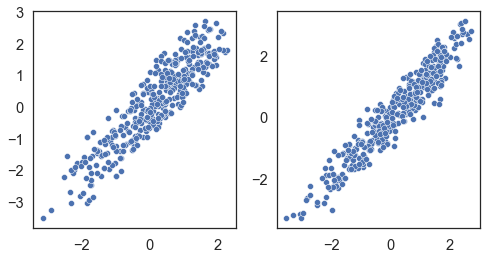

In [5]:
fig, axes = plt.subplots(1,2,figsize=(8,4))
sns.scatterplot(x=mu1.mean(axis=0), y=mu2.mean(axis=0), ax=axes[0])
sns.scatterplot(x=mu2.mean(axis=0), y=beta.mean(axis=0), ax=axes[1])

In [6]:
from pandas import DataFrame

## Load samples.
samples = read_csv(os.path.join('stan_results', '1plg_m2.tsv.gz'), sep='\t', compression='gzip')

In [7]:
## Extract parameters.
beta_mu   = samples.filter(regex='beta_mu\[').values
beta_1_pr = samples.filter(regex='beta_1_pr\[').values
sigma     = samples.filter(regex='sigma\[').values

## Load and prepare design matrices.
zscore = lambda x: (x - np.nanmean(x)) / np.nanstd(x)
X2 = read_csv(os.path.join('designs', 'X2.csv'))
X2 = X2.apply(zscore, 0).fillna(1).values
X3 = read_csv(os.path.join('designs', 'X3.csv'))
X3 = X3.values.astype(float)

mu0 = beta_mu @ X2[:,:-2].T + beta_1_pr @ X3.T * np.atleast_2d(sigma[:,0]).T
err = (beta - mu0).mean(axis=0)

df = DataFrame(dict(
    item = np.tile(np.arange(64) + 1, 6),
    distractor = np.tile(['md','md','md','pd','pd','pd'], 64),
    shape_set = np.tile([1,2,3,1,2,3], 64),
    delta = err 
))

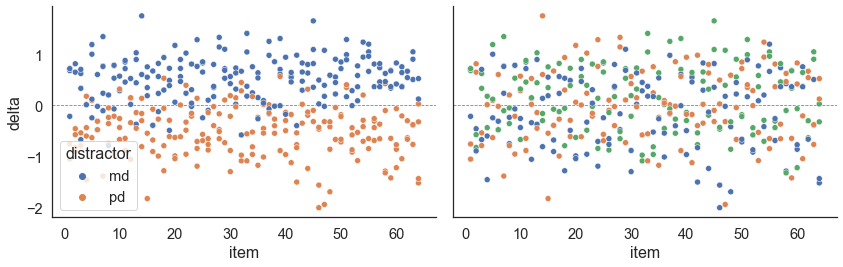

In [8]:
fig, axes = plt.subplots(1,2,figsize=(12,4),sharex=True,sharey=True)

sns.scatterplot(x='item', y='delta', hue='distractor', data=df, ax=axes[0])
axes[0].axhline(0, color='0.5', lw=0.8, linestyle='--', zorder=-1)

sns.scatterplot(x='item', y='delta', hue='shape_set', data=df, 
                palette=sns.color_palette(n_colors=3), ax=axes[1])
axes[1].axhline(0, color='0.5', lw=0.8, linestyle='--', zorder=-1)
axes[1].legend_.set_visible(False)

sns.despine()
plt.tight_layout()

#### 3pl

In [9]:
## Load samples.
samples = read_csv(os.path.join('stan_results', '3pl_m2.tsv.gz'), sep='\t', compression='gzip')

## Extract parameters.
beta_mu   = samples.filter(regex='beta_mu\[').values
beta_1_pr = samples.filter(regex='beta_1_pr\[').values
beta      = samples.filter(regex='beta\[').values
sigma     = samples.filter(regex='sigma\[').values

## Load and prepare design matrices.
zscore = lambda x: (x - np.nanmean(x)) / np.nanstd(x)
X2 = read_csv(os.path.join('designs', 'X2.csv'))
X2 = X2.apply(zscore, 0).fillna(1).values
X3 = read_csv(os.path.join('designs', 'X3.csv'))
X3 = X3.values.astype(float)

## Variance explained (level-1).
mu1 = beta_mu @ X2.T
r2 = 1 - np.var(beta - mu1, axis=1).mean() / np.var(beta, axis=1).mean() 
print('level-1 r2: %0.3f' %r2)

## Variance explained (level-2).
mu2 = beta_mu @ X2.T + beta_1_pr @ X3.T * np.atleast_2d(sigma[:,0]).T
r2 = 1 - np.var(beta - mu2, axis=1).mean() / np.var(beta, axis=1).mean() 
print('level-2 r2: %0.3f' %r2)

## Pooling factor (level-1).
pf1 = 1 - np.var(np.mean(mu2 - mu1, axis=1)) / np.mean(np.var(mu2 - mu1, axis=1))
print('level-1 pf: %0.3f' %pf1)

## Poolming factor (level-2).
pf2 = 1 - np.var(np.mean(beta - mu2, axis=1)) / np.mean(np.var(beta - mu2, axis=1))
print('level-2 pf: %0.3f' %pf2)

level-1 r2: 0.662
level-2 r2: 0.841
level-1 pf: 0.984
level-2 pf: 0.997


In [10]:
from scipy.stats import norm

## Extract parameters.
alpha_mu   = samples.filter(regex='alpha_mu\[').values
alpha      = samples.filter(regex='alpha\[').values
c = -0.625

## Load and prepare design matrices.
zscore = lambda x: (x - np.nanmean(x)) / np.nanstd(x)
X2 = read_csv(os.path.join('designs', 'X2.csv'))
X2 = X2.apply(zscore, 0).fillna(1).values

## Variance explained (level-1).
mu1 = norm.cdf(c + alpha_mu @ X2.T) * 5
r2 = 1 - np.var(alpha - mu1, axis=1).mean() / np.var(alpha, axis=1).mean() 
print('level-1 r2: %0.3f' %r2)

## Pooling factor (level-1).
pf1 = 1 - np.var(np.mean(alpha - mu1, axis=1)) / np.mean(np.var(alpha - mu1, axis=1))
print('level-1 pf: %0.3f' %pf1)

level-1 r2: 0.449
level-1 pf: 0.983


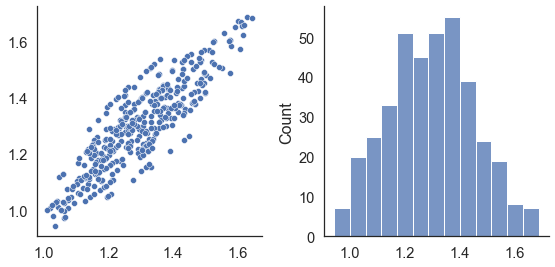

In [11]:
fig, axes = plt.subplots(1,2,figsize=(8,4))
sns.scatterplot(x=mu1.mean(axis=0), y=alpha.mean(axis=0), ax=axes[0])
sns.histplot(x=alpha.mean(axis=0), ax=axes[1])

sns.despine()
plt.tight_layout()